In [30]:
from data import InkmlDataset_PL
from models.lstm_ctc import LSTM_TemporalClassification_PL
from torchaudio.models.decoder import ctc_decoder
import matplotlib.pyplot as plt
import numpy as np
from data import *
from torchmetrics.text import EditDistance

# model = LSTM_TemporalClassification_PL().load_from_checkpoint("logs/lstm_ctc/version_1/checkpoints/epoch=22-step=20470.ckpt")
model = LSTM_TemporalClassification_PL(num_layers=3).load_from_checkpoint("logs/lstm_ctc/version_2/checkpoints/epoch=34-step=31150.ckpt")
dm = InkmlDataset_PL(root_dir="dataset/crohme2019")
dm.setup()
# Set the model to evaluation mode
model.eval()


LSTM_TemporalClassification_PL(
  (model): LSTM_TemporalClassification(
    (lstm): LSTM(3, 256, num_layers=3, batch_first=True, bidirectional=True)
    (fc): Linear(in_features=512, out_features=109, bias=True)
    (log_softmax): LogSoftmax(dim=2)
  )
  (criterion): CTCLoss()
)

In [40]:
tokens = list(model.vocab.keys())
beam_search = ctc_decoder(
    lexicon=None,
    tokens=tokens,
    nbest=3,
    blank_token='',
    sil_token='',
    unk_word='',
)

In [22]:
# x, y, lenx, leny = dm.test_dataset.__getitem__(0)
path = 'dataset/crohme2019/crohme2019/valid/20_em_31.inkml'
ink = Inkml(path)

traces = ink.getTraces()
combined_traces = np.vstack([np.array(trace)[:, :2] for trace in traces])
delta_traces = np.diff(combined_traces, axis=0)
zeros_filter = np.all(delta_traces == 0, axis=1)
delta_traces = delta_traces[~zeros_filter]
delta_traces = delta_traces / np.sqrt((np.square(delta_traces[:, 0]) + np.square(delta_traces[:, 1])))[:, np.newaxis]  # delta x, delta y --> delta x/sqrt(delta x^2 + delta y^2), delta y/sqrt(delta x^2 + delta y^2

pen_up = [np.array([0] * len(trace)) for trace in traces]
for _, arr in enumerate(pen_up):
    arr[0] = 1

combined_pen_up = np.concatenate(pen_up)[1:, np.newaxis][~zeros_filter]
combined_traces = np.hstack([delta_traces, combined_pen_up])
delta_traces_tensor = torch.tensor(combined_traces, dtype=torch.float32)

# item = dm.train_dataset.__getitem__(6)

output = model(delta_traces_tensor.unsqueeze(0).cuda())
output

tensor([[[-1.5751e+01, -1.4049e+01, -1.0481e+01,  ..., -1.8913e+01,
          -2.6853e+01, -2.1745e+01],
         [-5.9605e-07, -2.4145e+01, -3.4026e+01,  ..., -3.4242e+01,
          -5.2653e+01, -2.4613e+01],
         [-7.1526e-07, -2.5847e+01, -2.2222e+01,  ..., -3.1891e+01,
          -4.7918e+01, -2.4253e+01],
         ...,
         [ 0.0000e+00, -3.2548e+01, -4.2134e+01,  ..., -4.3921e+01,
          -6.2386e+01, -2.3966e+01],
         [ 0.0000e+00, -3.4000e+01, -4.3617e+01,  ..., -4.5726e+01,
          -6.2577e+01, -2.7541e+01],
         [-3.9339e-06, -2.3779e+01, -3.4631e+01,  ..., -3.0814e+01,
          -4.0822e+01, -1.4138e+01]]], device='cuda:0',
       grad_fn=<LogSoftmaxBackward0>)

X Right x Sup - Right 1 NoRel = Right X Right - Right 1 Right \times Right = Right F 

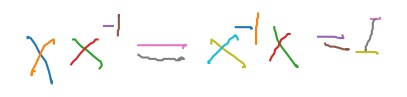

In [23]:
normal_prob = np.exp(output.squeeze(0).cpu().detach().numpy())

argmax = np.argmax(normal_prob, axis=1)
argmax = [tokens[i] for i in argmax if i != 0]
for i in argmax:
    print(i, end=" ")

# print([np.array(trace)[:, :2].shape for trace in ink.getTraces()])

plt.figure(figsize=(5,1))
plt.rcParams['axes.facecolor'] = 'black'  # Set background color to black
plt.axis('off')
for trace in ink.getTraces():
    trace_arr = np.array(trace)
    plt.plot(trace_arr[:, 0], - trace_arr[:, 1]) # invert y coordinate

In [44]:
beam_search_output = beam_search(output.cpu())
print(beam_search_output, end="\n\n")

output_str = ""
for i in [tokens[i] for i in beam_search_output[0][0].tokens.numpy() if i != 0]:
    output_str += i + " "
    
output_str

print(output_str)

beam_search_output[0][0]

# distance = EditDistance(output_str, )


[[CTCHypothesis(tokens=tensor([49, 32, 26, 25,  1, 32, 47, 45, 93, 32, 49, 32,  1, 32, 47, 32,  2, 32,
        93, 32, 56]), words=[], score=-3.727783366617757, timesteps=tensor([  1,  28,  29,  49,  50,  56,  57,  67,  68, 114, 115, 145, 146, 154,
        155, 169, 170, 193, 194, 214, 215], dtype=torch.int32)), CTCHypothesis(tokens=tensor([49, 32, 49, 25,  1, 32, 47, 45, 93, 32, 49, 32,  1, 32, 47, 32,  2, 32,
        93, 32, 56]), words=[], score=-4.20632348912676, timesteps=tensor([  1,  28,  29,  49,  50,  56,  57,  67,  68, 114, 115, 145, 146, 154,
        155, 169, 170, 193, 194, 214, 215], dtype=torch.int32)), CTCHypothesis(tokens=tensor([49, 32, 26, 25,  1, 32, 47, 45, 93, 32, 26, 32,  1, 32, 47, 32,  2, 32,
        93, 32, 56]), words=[], score=-4.2575670923562825, timesteps=tensor([  1,  28,  29,  49,  50,  56,  57,  67,  68, 114, 115, 145, 146, 154,
        155, 169, 170, 193, 194, 214, 215], dtype=torch.int32))]]

X Right x Sup - Right 1 NoRel = Right X Right - Right 1 Righ

CTCHypothesis(tokens=tensor([49, 32, 26, 25,  1, 32, 47, 45, 93, 32, 49, 32,  1, 32, 47, 32,  2, 32,
        93, 32, 56]), words=[], score=-3.727783366617757, timesteps=tensor([  1,  28,  29,  49,  50,  56,  57,  67,  68, 114, 115, 145, 146, 154,
        155, 169, 170, 193, 194, 214, 215], dtype=torch.int32))

In [49]:
" ".join(["a", "b", "c"])

'a b c'